## Imports

In [7]:
%load_ext autoreload
%autoreload 2

%env TFDS_DATA_DIR=/Users/paul/scratch/tensorflow_datasets

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import *

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import DataHandler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: TFDS_DATA_DIR=/Users/paul/scratch/tensorflow_datasets


> **Note**: In `oodeel.methods.odin`, the import `from tensorflow.python.keras.utils.generic_utils import get_custom_objects` should be replaced with `from tensorflow.python.keras.utils import get_custom_objects`


## MNIST (0-4) vs MNIST (5-9)

### Data and model loading
ID data: MNIST (0-4), OOD data: MNIST (5-9)

In [8]:
data_handler = DataHandler()
normalize = lambda x: x / 255
mnist_ds = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)

# train / test set
x_train, _ = data_handler.filter_tfds(mnist_ds['train'], inc_labels=list(range(5)))
x_test, x_ood = data_handler.filter_tfds(mnist_ds['test'], inc_labels=list(range(5)))

# id / ood set
x_id = x_test

In [9]:
load = True
checkpoint_path = '../saved_models/mnist_5'

if load:
    model = tf.keras.models.load_model(checkpoint_path)
else:
    # define model
    num_classes = 5
    input_shape = (28, 28, 1)

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.summary()

    # train model
    batch_size = 128
    epochs = 15

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train.batch(batch_size), validation_data=x_test.batch(batch_size), epochs=epochs)
    model.save(checkpoint_path)

### DKNN score

auroc       0.974568
fpr95tpr    0.115587
Name: mnist-0-4-vs-5-10, dtype: float64


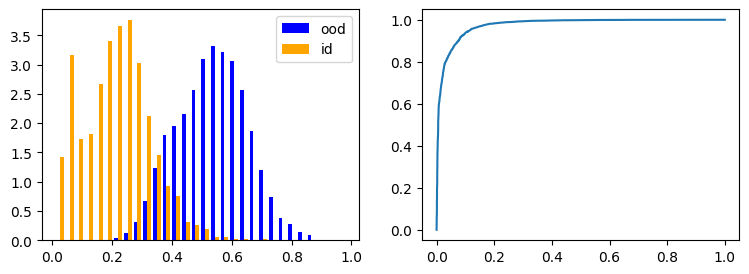

In [14]:
batch_size = 128

oodmodel = DKNN(nearest=50)
oodmodel.fit(model, x_train.take(10000).batch(batch_size))
scores_id = oodmodel.score(x_id.take(10000).batch(batch_size))
scores_ood = oodmodel.score(x_ood.take(10000).batch(batch_size))

# auroc / fpr95
scores = np.concatenate([scores_id, scores_ood])
labels= np.array([0] * len(scores_id) + [1] * len(scores_ood))
fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels,
    metrics=["auroc", "fpr95tpr"],
)
metrics_first_vs_last = pd.Series(metrics, name='mnist-0-4-vs-5-10')
print(metrics_first_vs_last)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.show()

## MNIST vs Fashion MNIST


### Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [15]:
data_handler = DataHandler()
normalize = lambda x: x / 255
ds1 = data_handler.load_tfds('mnist', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('fashion_mnist', preprocess=True, preprocessing_fun=normalize)

# train / test set
x_train, x_test = ds1['train'], ds1['test']
# id / ood set
x_id, x_ood = ds1["test"], ds2["test"]
x_test_ood = data_handler.merge_tfds(x_id.take(1000), x_ood.take(1000), shuffle='True')

2023-02-10 15:52:51.708648: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [16]:
load = True
checkpoint_path = '../saved_models/mnist_10'

if load:
    model = tf.keras.models.load_model(checkpoint_path)
else:
    # define model
    num_classes = 10
    input_shape = (28, 28, 1)

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    model.summary()

    # train model
    batch_size = 128
    epochs = 15

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train.batch(batch_size), validation_data=x_test.batch(batch_size), epochs=epochs)
    model.save(checkpoint_path)

### DKNN score

2023-02-10 16:04:45.311473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


auroc       0.997319
fpr95tpr    0.009200
Name: mnist-10-vs-fashion, dtype: float64


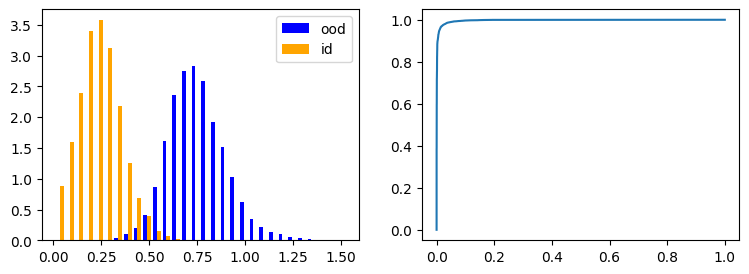

In [18]:
oodmodel = DKNN(nearest=50)
oodmodel.fit(model, x_train.take(10000).batch(batch_size))
scores_id = oodmodel.score(x_id.take(10000).batch(batch_size)) 
scores_ood = oodmodel.score(x_ood.take(10000).batch(batch_size))

# auroc / fpr95
scores = np.concatenate([scores_id, scores_ood])
labels= np.array([0] * len(scores_id) + [1] * len(scores_ood))
fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels,
    metrics=["auroc", "fpr95tpr"]
)
metrics_fashion = pd.Series(metrics, name='mnist-10-vs-fashion')
print(metrics_fashion)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.show()

## CIFAR-10 vs [SVHN, LSUN, iSUN, Texture]

### ID Data and model loading

In [19]:
data_handler = DataHandler()
normalize = lambda x: x / 255
ds1 = data_handler.load_tfds('cifar10', preprocess=True, preprocessing_fun=normalize)
ds2 = data_handler.load_tfds('svhn_cropped', preprocess=True, preprocessing_fun=normalize)

# train / test set
x_train, x_test = ds1['train'], ds1['test']
# id set
x_id= ds1["test"]

# load model
# (to train the model, run: python -m notebooks.train_cifar10)
model = tf.keras.models.load_model("../saved_models/cifar10_dknn/")

# model = tf.keras.models.load_model("../saved_models/cifar10/")
# best: cifar10 => 200 epochs, cosine scheduler, [0, 1]

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [01:08<00:00, 68.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [01:09<00:00, 69.98s/ url]


Dataset cifar10 downloaded and prepared to /Users/paul/scratch/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


Dl Completed...:   0%|          | 0/3 [03:22<?, ? url/s]

### OOD data: SVHN
ID data: CIFAR-10, OOD data: SVHN

2023-02-04 01:04:37.096322: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


auroc       0.865995
fpr95tpr    0.370100
Name: cifar-vs-svhn, dtype: float64


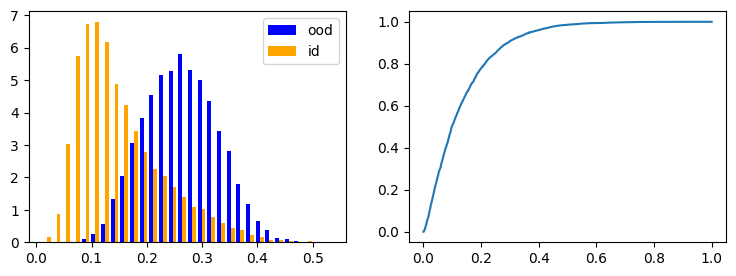

In [ ]:
# ood dataset
ds2 = data_handler.load_tfds('svhn_cropped', preprocess=True, preprocessing_fun=normalize)
x_ood = ds2['test']

oodmodel = DKNN(nearest=50, output_layers_id=['pool1'])
oodmodel.fit(model, x_train.take(10000).batch(batch_size))
scores_id = oodmodel.score(x_id.take(10000).batch(batch_size))
scores_ood = oodmodel.score(x_ood.take(10000).batch(batch_size))

# auroc / fpr95
scores = np.concatenate([scores_id, scores_ood])
labels= np.array([0] * len(scores_id) + [1] * len(scores_ood))
fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels,
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_svhn = pd.Series(metrics, name='cifar-vs-svhn')
print(metrics_cifar_svhn)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.show()

### OOD data: LSUN
ID data: CIFAR-10, OOD data: LSUN

Found 10000 files belonging to 1 classes.


2023-02-04 01:04:43.879091: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


auroc       0.998942
fpr95tpr    0.002600
Name: cifar-vs-lsun, dtype: float64


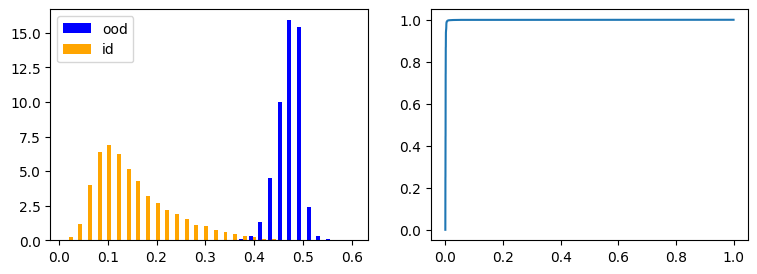

In [ ]:
import tensorflow as tf
LSUN_root = '/data/home/yannick.prudent/ood_dataset/LSUN'
lsun_ds = tf.keras.utils.image_dataset_from_directory(
    LSUN_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None
)
# ood dataset
x_ood = lsun_ds

oodmodel = DKNN(nearest=50, output_layers_id=['pool1'])
oodmodel.fit(model, x_train.take(10000))
scores_id, scores_ood = oodmodel.score([x_id.take(10000), x_ood.take(10000)])

# auroc / fpr95
scores = np.concatenate([scores_id, scores_ood])
labels= np.array([0] * len(scores_id) + [1] * len(scores_ood))
fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels,
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_lsun = pd.Series(metrics, name='cifar-vs-lsun')
print(metrics_cifar_lsun)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.show()

### OOD data: iSUN
ID data: CIFAR-10, OOD data: iSUN

Found 8925 files belonging to 1 classes.


2023-02-04 01:21:25.941738: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


auroc       0.997885
fpr95tpr    0.004600
Name: cifar-vs-isun, dtype: float64


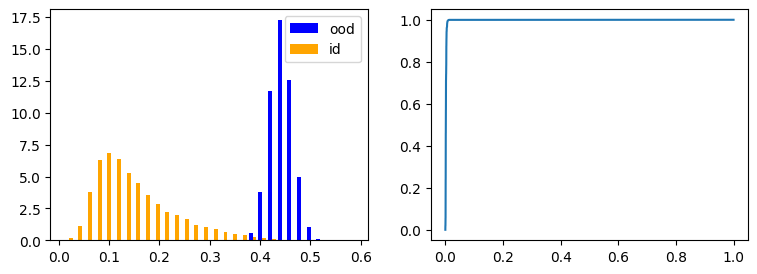

In [ ]:
import tensorflow as tf
iSUN_root = '/data/home/yannick.prudent/ood_dataset/iSUN'
isun_ds = tf.keras.utils.image_dataset_from_directory(
    iSUN_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None
)
# ood dataset
x_ood = isun_ds

oodmodel = DKNN(nearest=50, output_layers_id=['pool1'])
oodmodel.fit(model, x_train.take(10000))
scores_id, scores_ood = oodmodel.score([x_id.take(10000), x_ood.take(10000)])

# auroc / fpr95
scores = np.concatenate([scores_id, scores_ood])
labels= np.array([0] * len(scores_id) + [1] * len(scores_ood))
fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels,
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_isun = pd.Series(metrics, name='cifar-vs-isun')
print(metrics_cifar_isun)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.show()

### OOD data: Texture
ID data: CIFAR-10, OOD data: Texture

Found 5640 files belonging to 47 classes.


2023-02-04 01:29:33.423863: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


auroc       0.997419
fpr95tpr    0.006700
Name: cifar-vs-texture, dtype: float64


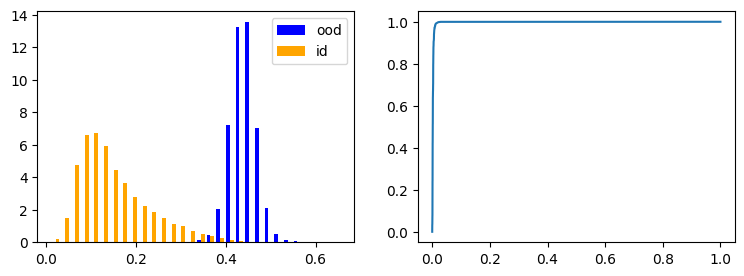

In [ ]:
import tensorflow as tf
texture_root = '/data/home/yannick.prudent/ood_dataset/dtd/images'
texture_ds = tf.keras.utils.image_dataset_from_directory(
    texture_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None,
)
# ood dataset
x_ood = texture_ds

oodmodel = DKNN(nearest=50, output_layers_id=['pool1'])
oodmodel.fit(model, x_train.take(10000))
scores_id, scores_ood = oodmodel.score([x_id.take(10000), x_ood.take(10000)])

# auroc / fpr95
scores = np.concatenate([scores_id, scores_ood])
labels= np.array([0] * len(scores_id) + [1] * len(scores_ood))
fpr, tpr = get_curve(scores, labels)
metrics = bench_metrics(
    scores, labels,
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_texture = pd.Series(metrics, name='cifar-vs-texture')
print(metrics_cifar_texture)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.subplot(121)
plt.hist((scores_ood, scores_id), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.show()

## Results

In [ ]:
pd.concat([metrics_first_vs_last, metrics_fashion, metrics_cifar_svhn, metrics_cifar_lsun, metrics_cifar_isun, metrics_cifar_texture], axis=1).T

,auroc,fpr95tpr
mnist-0-4-vs-5-10,0.975215,0.107803
mnist-10-vs-fashion,0.997144,0.010400
cifar-vs-svhn,0.865995,0.370100
cifar-vs-lsun,0.998942,0.002600
cifar-vs-isun,0.997885,0.004600
cifar-vs-texture,0.997419,0.006700
